In [1]:
import os,glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,precision_recall_fscore_support,precision_score,recall_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pickle
from sklearn.pipeline import Pipeline

In [2]:
filename = "appceleratorstudio.csv"
data = pd.read_csv(filename)
print(data.isnull().sum())
# print(data.describe())
data = data.drop(['issuekey'], axis = 1)

data = data.dropna(how='any')

print(data.shape)
# print(data.describe())
print(data.groupby('storypoint').size())

issuekey        0
title           0
description    43
storypoint      0
dtype: int64
(2876, 3)
storypoint
1      148
2      112
3      571
5     1126
8      751
9        1
13     137
20      22
21       3
34       1
40       4
dtype: int64


In [3]:
# data.head()

In [4]:
data.loc[data.storypoint <= 2, 'storypoint'] = 0 #small
data.loc[(data.storypoint > 2) & (data.storypoint <= 5), 'storypoint'] = 1 #medium
data.loc[data.storypoint > 5, 'storypoint'] = 2 #big


print(data.groupby('storypoint').size())

storypoint
0     260
1    1697
2     919
dtype: int64


In [5]:
data.describe()

,storypoint
count,2876.000000
mean,1.229138
std,0.597967
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [6]:
data['titDescription'] = data[['title', 'description']].apply(lambda x: ' '.join(x.map(str)), axis=1)
data['titDescriptiontLEN'] = data['titDescription'].str.len()

data = data.drop(['title'], axis = 1)
data = data.drop(['description'], axis = 1)
print(data.shape)


(2876, 3)


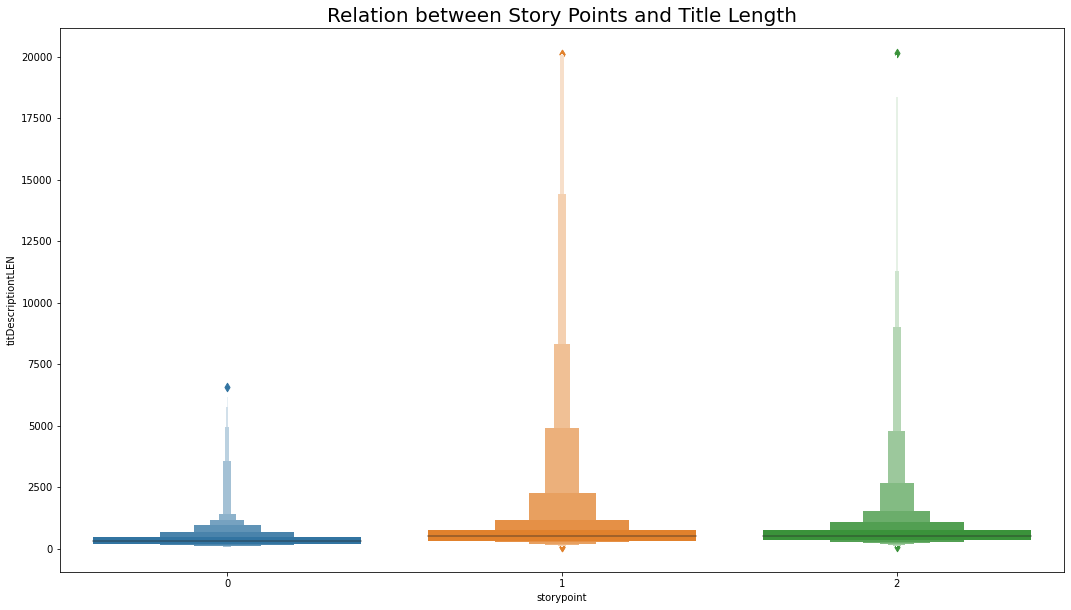

In [7]:
plt.rcParams['figure.figsize'] = (18, 10)
sns.boxenplot(x = data['storypoint'], y = data['titDescriptiontLEN'])
plt.title('Relation between Story Points and Title Length', fontsize = 20)
# plt.savefig('classes representation with sampling after new segmentation')
# plt.hist(data.storypoint, bins=20, alpha=0.6, color='y')
# plt.title("#Items per Point")
# plt.xlabel("Points")
# plt.ylabel("Count")
plt.show()

# plt.savefig('items per point')


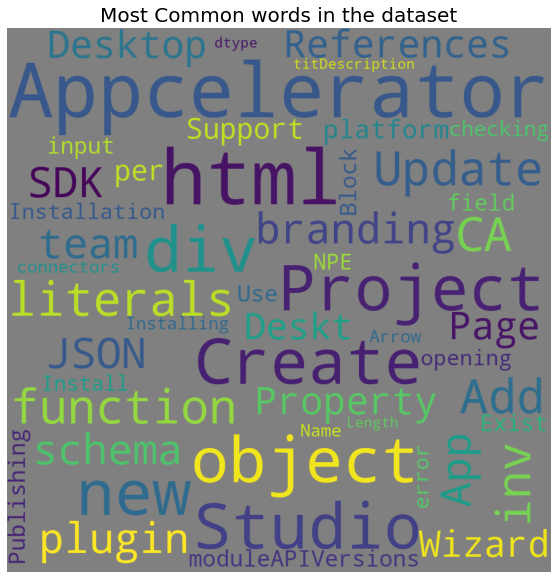

In [8]:
wordcloud = WordCloud(background_color = 'gray', width = 1000, height = 1000, max_words = 50).generate(str(data['titDescription']))
plt.rcParams['figure.figsize'] = (10, 10)
plt.title('Most Common words in the dataset', fontsize = 20)
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('common words')
plt.show()

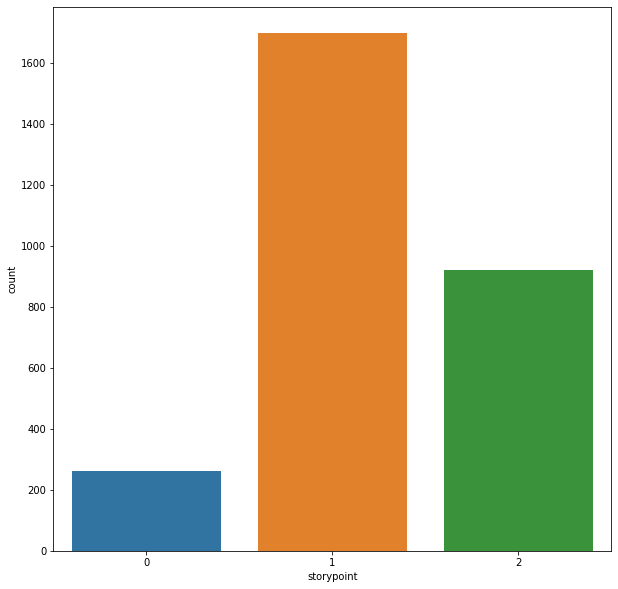

In [9]:
sns.countplot(x='storypoint', data=data)

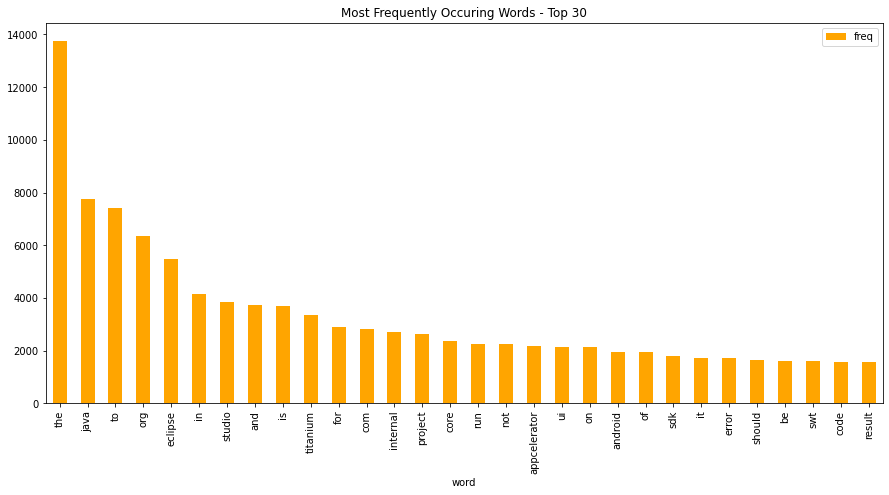

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer()
words = cv.fit_transform(data['titDescription'].values.astype('U'))
sum_words = words.sum(axis=0)
#
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'orange')
plt.title("Most Frequently Occuring Words - Top 30")
plt.savefig('top common words')
plt.show()

In [11]:
# checking the most common words in the whole dataset
# import pickle
# corpusTitDescription = []
# n=data.shape[0]
# for i in range(0, n):

#   review = re.sub('[^a-zA-Z]', ' ', data['titDescription'].values.astype('U')[i])

#   review = review.lower()
#   review = review.split()
#   ps = PorterStemmer()
#   # stemming
#   review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]

#   # joining them back with space
#   review = ' '.join(review)

#   corpusTitDescription.append(review)
# with open("appcelerator2_pickle.txt", "wb") as fp:   #Pickling
#     pickle.dump(corpusTitDescription, fp)


In [12]:
with open("appcelerator2_pickle.txt", "rb") as fp:   # Unpickling
    corpusTitDescription = pickle.load(fp)
data = data.reset_index(drop=True)    
x = tfidf.fit_transform(corpusTitDescription).toarray()
y = data.iloc[:, 0]
# y = data.pop('storypoint')
# x = data

# print('x:',x)
# print('y:',y)
print('x_shape',x.shape)
print('y_shape',y.shape)

x_shape (2876, 7002)
y_shape (2876,)


In [13]:
smt = SMOTE()
x, y = smt.fit_resample(x, y)
print('Y_train_classes_counts',np.bincount(y))

Y_train_classes_counts [1697 1697 1697]


In [14]:
#Title
# splitting the training data into train and valid sets
# x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.20 ,random_state=seed,shuffle=True,stratify=y)
# print('x_train_shape',x_train.shape)
# print('x_test_shape',x_test.shape)
# print('y_train_shape',y_train.shape)
# print('x_test_shape',y_test.shape)

# standardization
sc = StandardScaler()
# mm=MinMaxScaler()
# x = sc.fit_transform(x)
# x = mm.fit_transform(x)
# print('Y_train_value_counts',y_train.value_counts())

In [15]:
# param_grid = {'scale_pos_weight':[1, 10, 25, 50, 75, 99, 100, 1000]}
# model = model_selection.GridSearchCV(XGBClassifier(), param_grid, cv=10,scoring='accuracy')
# model.fit(x_train, y_train)
# print('best parameters',model.best_params_)

In [ ]:
seed=50

models = []
models.append(('SVCLw', LinearSVC(class_weight='balanced')))
models.append(('SVCLd', LinearSVC()))
models.append(('LR', LogisticRegression(class_weight='balanced')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('xGBw', XGBClassifier(scale_pos_weight=99)))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    pipeline = Pipeline([('transformer', sc), ('estimator', model)])
    kfold = model_selection.StratifiedKFold(n_splits=10,random_state=seed,shuffle=True)
    fit = model_selection.cross_val_score(pipeline, x, y, cv=kfold, scoring='accuracy')

    
    results.append(fit)
    names.append(name)
    
    msg_accuracy = "%s: %f (%f)" % (name, fit.mean(), fit.std())
    
    y_pred = model_selection.cross_val_predict(model, x, y, cv=kfold)
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    precision=precision_score(y, y_pred,average='weighted')
    recall=recall_score(y, y_pred,average='weighted')
    f_score=f1_score(y, y_pred,average='weighted')
    support=precision_recall_fscore_support(y,y_pred,average='weighted')
#     roc_curve=roc_auc_score(y,y_pred,average='weighted')
#     precision_recall_curve=precision_recall_curve(y,y_pred,average='weighted')
    print(name)
    print('Accuracy:',msg_accuracy)
    print('precision:',precision)
    print('recall:',recall)
    print('f1_score:',f_score)
    print('precision_recall_fscore_support:',support)
#     print('roc_auc_score:',roc_curve)
#     print('precision_recall_curve:',precision_recall_curve)
    print(cm)
    print(cr)
    print('================================================================')
    

SVCLw
Accuracy: SVCLw: 0.822625 (0.012587)
precision: 0.8116905688014585
recall: 0.8145747397367904
f1_score: 0.8097745018583465
precision_recall_fscore_support: (0.8116905688014585, 0.8145747397367904, 0.8097745018583465, None)
[[1673   19    5]
 [ 157 1099  441]
 [  44  278 1375]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1697
           1       0.79      0.65      0.71      1697
           2       0.76      0.81      0.78      1697

    accuracy                           0.81      5091
   macro avg       0.81      0.81      0.81      5091
weighted avg       0.81      0.81      0.81      5091

SVCLd
Accuracy: SVCLd: 0.822625 (0.013398)
precision: 0.8116905688014585
recall: 0.8145747397367904
f1_score: 0.8097745018583465
precision_recall_fscore_support: (0.8116905688014585, 0.8145747397367904, 0.8097745018583465, None)
[[1673   19    5]
 [ 157 1099  441]
 [  44  278 1375]]
              precision    recall  f1-score   suppo